In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from model import Net, device
from dataset import MyData

samples = torch.load('Kislovodsk.pt')
IMG_SIZE = samples[0].shape
PATH_TO_RESULTS = './Tests/Kislovodsk/'
num_epochs = 3e+4

Selected devie is cuda:0


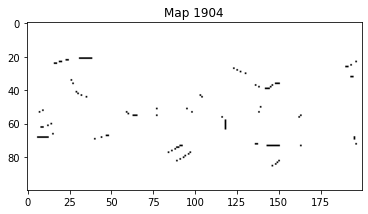

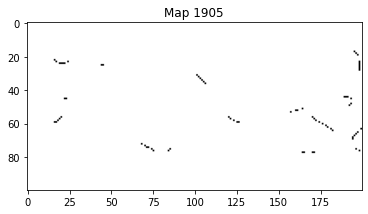

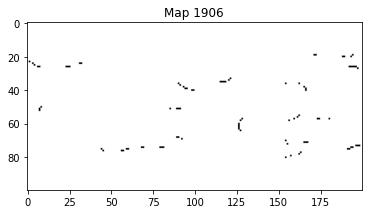

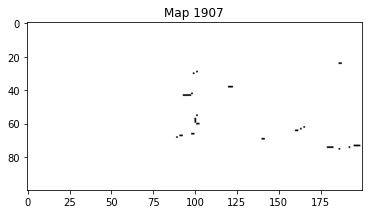

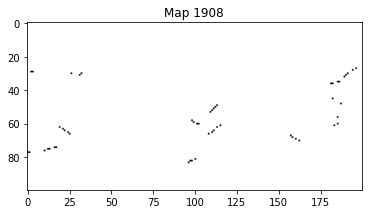

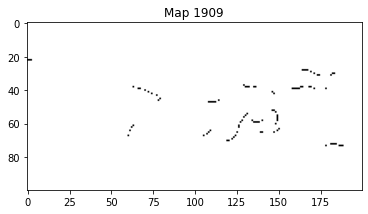

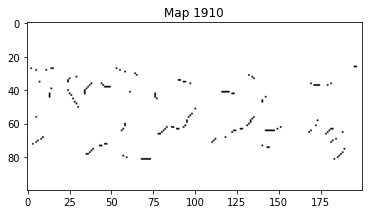

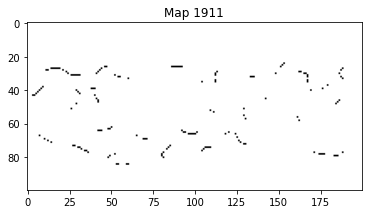

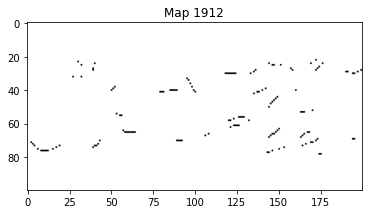

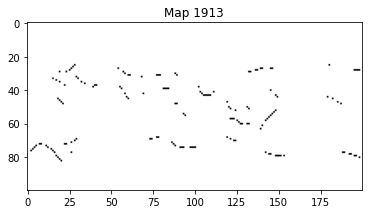

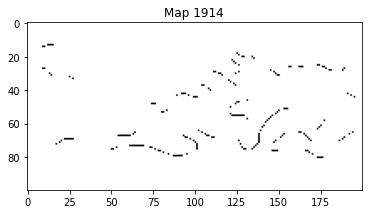

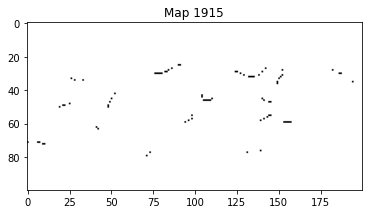

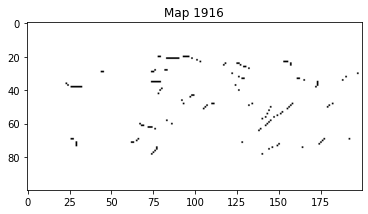

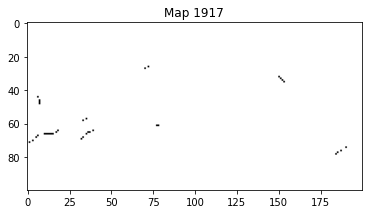

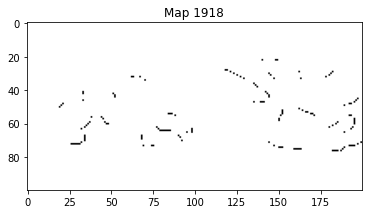

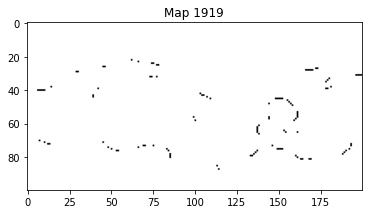

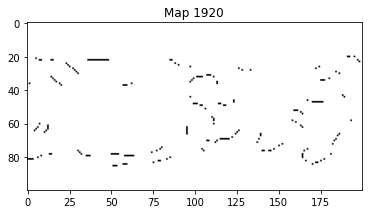

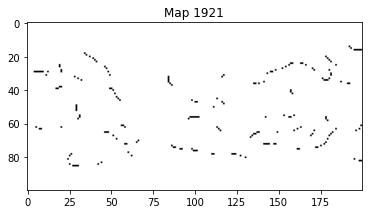

In [7]:
for i, sample in enumerate(samples):
    plt.imshow(sample, cmap='gray')
    # plt.axis('off')
    plt.title(f'Map {1904 + i}')
    plt.show()

In [ ]:
os.makedirs(PATH_TO_RESULTS, exist_ok=True)
for i, sample in tqdm(enumerate(samples), desc='Samples', total=len(samples)):
    dataset = MyData(path_or_img=sample, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1)
    dataset_list = [dataset]
    map_num = 1904 + i
    cur_dir = os.path.join(PATH_TO_RESULTS, str(map_num))
    os.mkdir(cur_dir)
    res = []
    for j in range(9):
        model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
        model.to(device)
        model.start_training(num_epochs=num_epochs, my_weight=0.1, need_save=False, need_plot=False)
        predictions = model.test_model(need_plot=False)
        prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        plt.title(f'Filaments on map №{map_num}')
        plt.subplot(1, 2, 2)
        plt.imshow(prediction, cmap='PuOr')
        plt.axis('off')
        plt.title('Model prediction')
        plt.savefig(os.path.join(cur_dir, f'prediction_{j+1}.png'))
        plt.close()
        plt.clf()
        torch.save(model.state_dict(), os.path.join(cur_dir, f'model_{j+1}.pt'))
        res.append(prediction)
    plt.figure(figsize=(20, 10))
    plt.suptitle(f'All runs on map №{map_num}')
    for n, r in enumerate(res):
        plt.subplot(3, 3, n+1)
        plt.imshow(r, cmap='PuOr')
        plt.axis('off')
    plt.savefig(os.path.join(cur_dir, 'predictions_all.png'))
    plt.close()
    plt.clf()